# Cars Recognition

The goal of this project is to practice Transfer learning and Fine Tuning on the task of recognizing car brands from a photograph.

In [78]:
import os, re, math, random, time, gc, string, pickle, shutil, pathlib, itertools
import numpy as np, pandas as pd, matplotlib.pyplot as plt, PIL

import tensorflow as tf
#import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import *
from tensorflow.keras.activations import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.layers import *
from tensorflow.keras.layers.experimental.preprocessing import *
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.optimizers.schedules import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from PIL import Image
from IPython.display import clear_output
from tqdm.notebook import tqdm

In [56]:
sample_submission_path = "./sf-dl-car-classification_project_7/sample-submission.csv"
train_path = "./sf-dl-car-classification_project_7/train"
sub_path = "./sf-dl-car-classification_project_7/test_upload"


#### EDA

We need to classify cars belonging to 10 classes. The distribution among these classes is fairly even

<AxesSubplot:xlabel='Category'>

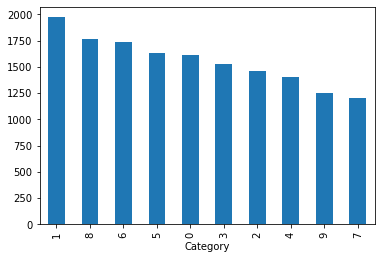

In [32]:
train_df = pd.read_csv(train_path+"/train.csv")
train_df.Category.value_counts().plot(kind = "bar", xlabel = "Category")

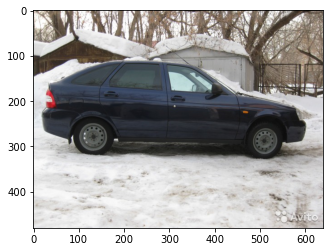

(640, 480)

In [45]:
image = PIL.Image.open(train_path+'/train/0/100380.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

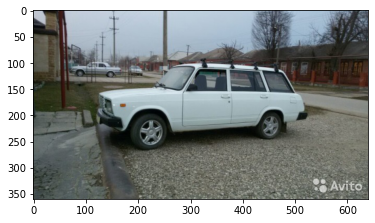

(640, 360)

In [49]:
image = PIL.Image.open(sub_path  +"/805.jpg")
imgplot = plt.imshow(image)
plt.show()
image.size

Train:


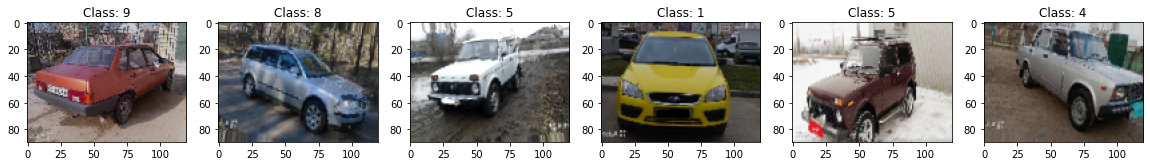

Val:


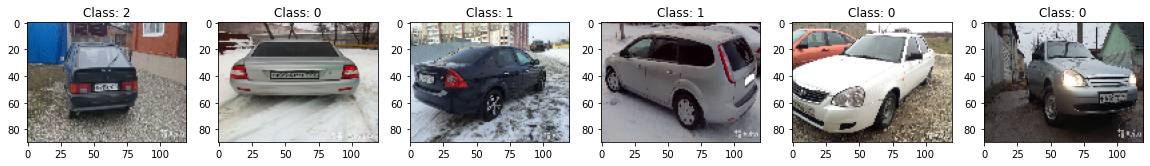

Sub:


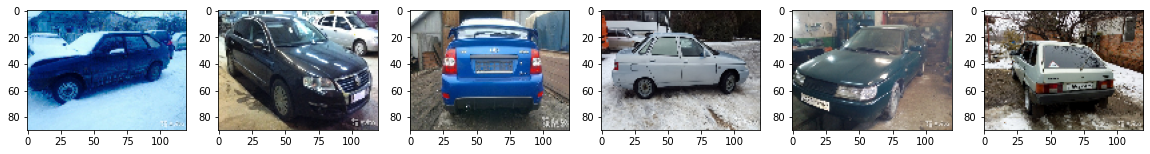

In [342]:
def show_first_images(generator, count=6, labels=True, figsize=(20, 5), normalized=False):
  generator = itertools.islice(generator, count)
  fig, axes = plt.subplots(nrows=1, ncols=count, figsize=figsize)
  for batch, ax in zip(generator, axes):
    if labels:
      img_batch, labels_batch = batch
      img, label = img_batch[0], np.argmax(labels_batch[0]) #берем по одному изображению из каждого батча
    else:
      img_batch = batch
      img = img_batch[0]
    if not normalized:
      img = img.astype(np.uint8)
    ax.imshow(img)
    # метод imshow принимает одно из двух:
    # - изображение в формате uint8, яркость от 0 до 255
    # - изображение в формате float, яркость от 0 до 1
    if labels:
      ax.set_title(f'Class: {label}')
  plt.show()

print('Train:')
show_first_images(train_generator)

print('Val:')
show_first_images(val_generator)

print('Sub:')
show_first_images(sub_generator, labels=False)

In [114]:
image_size = (90, 120)
batch_size = 32
RANDOM_SEED = 42
input_shape = (*image_size, 3)

In [285]:
train_datagen = ImageDataGenerator(
    #rescale=1/255,
    validation_split=0.2,
    # ниже параметры аугментаций:
    horizontal_flip=True,
    rotation_range=10,
    shear_range=0.2,
    brightness_range=(0.8, 1.2),
)

val_datagen = ImageDataGenerator(
    #rescale=1/255,
    validation_split=0.2,
)

sub_datagen = ImageDataGenerator(
    #rescale=1/255
)

#### Data Augmentation

In [286]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=0,
    subset='training'
)

val_generator = val_datagen.flow_from_directory(
    train_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=0,
    subset='validation'
)

sub_generator = sub_datagen.flow_from_dataframe( 
    dataframe=pd.read_csv(sample_submission_path),
    directory=sub_path,
    x_col="Id",
    y_col=None,
    class_mode=None,
    target_size=image_size,
    batch_size=batch_size,
    shuffle=False
)

Found 12452 images belonging to 10 classes.
Found 3109 images belonging to 10 classes.
Found 6675 validated image filenames.


#### EfficientNetB0

In [343]:
model = Sequential([
  EfficientNetB0(weights='imagenet', input_shape=(*image_size, 3), include_top=False), #предобученная нейросеть из модуля keras.applications
  GlobalMaxPool2D(),
  Dropout(0.5),
  Dense(10)
])

model.compile(
    loss=CategoricalCrossentropy(from_logits=True),
    optimizer=Adam(ExponentialDecay(1e-3, 100, 0.9)),
    metrics='accuracy'
)

In [344]:
model.fit(train_generator, validation_data=val_generator, epochs=1)

390/390 [==============================] - 1090s 3s/step - loss: 2.1743 - accuracy: 0.3984 - val_loss: 1.0196 - val_accuracy: 0.6359


In [ ]:
def plot_history(history):
    plt.figure(figsize=(10,5))
    #plt.style.use('dark_background')
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'g', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    #plt.figure()
    plt.figure(figsize=(10,5))
    #plt.style.use('dark_background')
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_history(history)

loss: 1.1413 - accuracy: 0.6037

### Fine Tunung

EfficientNetB7 will as a basis for transfer learning. Let's fine tune it

#### Step 1

 Base model stays freezed

In [295]:
base_model_02= EfficientNetB7(weights='imagenet', include_top=False, input_shape=input_shape)
base_model_02.trainable = False

Let's add fully-connected and logistic layers 

model_02=Sequential()
model_02.add(base_model_02)
model_02.add(GlobalAveragePooling2D(),)
model_02.add(Dense(10, activation='softmax'))
model_02.summary()

In [ ]:
print("The hodel has ", len(model_02.layers), " layers")
print(len(model_02.trainable_variables), " of them are trainable")

In [298]:
for layer in model_02.layers:
    print(layer, layer.trainable)

<keras.engine.functional.Functional object at 0x00000217DF9EF5E0> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x00000217C5824430> True
<keras.layers.core.dense.Dense object at 0x00000217E38C5EE0> True


In [299]:
model_02.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

In [300]:
scores = model_02.evaluate(val_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

98/98 [==============================] - 333s 3s/step - loss: 2.3282 - accuracy: 0.1042
Accuracy: 10.42%


Let's assign callbacks for fitting the model. The first of them is for saving checkpoints of the model, the second one should stop the learning if the model starts to overfit.

In [301]:
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
earlystop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
callbacks_list = [checkpoint, earlystop]

In [302]:
# Обучаем
history = model_02.fit(
                    train_generator,
                    steps_per_epoch = train_generator.samples//train_generator.batch_size,
                    validation_data = val_generator, 
                    validation_steps = val_generator.samples//val_generator.batch_size,
                    epochs = 5,
                    callbacks = callbacks_list
                    )

Epoch 1/5
389/389 [==============================] - ETA: 0s - loss: 1.8667 - accuracy: 0.3280
Epoch 00001: saving model to best_model.hdf5
389/389 [==============================] - 1824s 5s/step - loss: 1.8667 - accuracy: 0.3280 - val_loss: 1.6870 - val_accuracy: 0.4159
Epoch 2/5
389/389 [==============================] - ETA: 0s - loss: 1.6181 - accuracy: 0.4300
Epoch 00002: saving model to best_model.hdf5
389/389 [==============================] - 1738s 4s/step - loss: 1.6181 - accuracy: 0.4300 - val_loss: 1.5632 - val_accuracy: 0.4449
Epoch 3/5
389/389 [==============================] - ETA: 0s - loss: 1.5323 - accuracy: 0.4651 
Epoch 00003: saving model to best_model.hdf5
389/389 [==============================] - 4406s 11s/step - loss: 1.5323 - accuracy: 0.4651 - val_loss: 1.5223 - val_accuracy: 0.4678
Epoch 4/5
389/389 [==============================] - ETA: 0s - loss: 1.4846 - accuracy: 0.4792
Epoch 00004: saving model to best_model.hdf5
389/389 [==============================

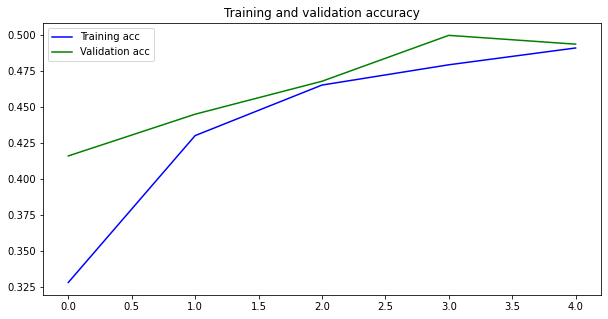

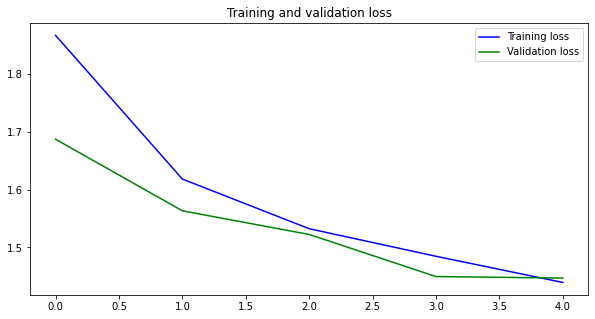

In [303]:
plot_history(history)

In [304]:
scores = model_02.evaluate(val_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

98/98 [==============================] - 322s 3s/step - loss: 1.4465 - accuracy: 0.4934
Accuracy: 49.34%


# Step 2

Now we can unfreeze the half of base models layers and fit it with the less learning rate

In [313]:
base_model_02.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = len(base_model_02.layers)//2

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model_02.layers[:fine_tune_at]:
  layer.trainable =  False

In [314]:
len(base_model_02.trainable_variables)

357

In [315]:
for layer in model_02.layers:
    print(layer, layer.trainable)

<keras.engine.functional.Functional object at 0x00000217DF9EF5E0> True
<keras.layers.pooling.GlobalAveragePooling2D object at 0x00000217C5824430> True
<keras.layers.core.dense.Dense object at 0x00000217E38C5EE0> True


In [316]:
LR=0.0001
model_02.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(learning_rate=LR), metrics=["accuracy"])

In [317]:
model_02.summary()

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional)  (None, 3, 4, 2560)       64097687  
                                                                 
 global_average_pooling2d_19  (None, 2560)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_17 (Dense)            (None, 10)                25610     
                                                                 
Total params: 64,123,297
Trainable params: 59,262,562
Non-trainable params: 4,860,735
_________________________________________________________________


In [318]:
scores = model_02.evaluate(val_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

98/98 [==============================] - 381s 4s/step - loss: 1.5342 - accuracy: 0.4522
Accuracy: 45.22%


In [319]:
history = model_02.fit(
                    train_generator,
                    steps_per_epoch = train_generator.samples//train_generator.batch_size,
                    validation_data = val_generator, 
                    validation_steps = val_generator.samples//val_generator.batch_size,
                    epochs = 5,
                    callbacks=callbacks_list
                    )

Epoch 1/5
389/389 [==============================] - ETA: 0s - loss: 1.2653 - accuracy: 0.5460 
Epoch 00001: saving model to best_model.hdf5
389/389 [==============================] - 8150s 21s/step - loss: 1.2653 - accuracy: 0.5460 - val_loss: 0.8715 - val_accuracy: 0.6823
Epoch 2/5
389/389 [==============================] - ETA: 0s - loss: 0.6703 - accuracy: 0.7597 
Epoch 00002: saving model to best_model.hdf5
389/389 [==============================] - 11078s 29s/step - loss: 0.6703 - accuracy: 0.7597 - val_loss: 0.7077 - val_accuracy: 0.7545
Epoch 3/5
389/389 [==============================] - ETA: 0s - loss: 0.4314 - accuracy: 0.8482 
Epoch 00003: saving model to best_model.hdf5
389/389 [==============================] - 6471s 17s/step - loss: 0.4314 - accuracy: 0.8482 - val_loss: 0.6614 - val_accuracy: 0.7748
Epoch 4/5
389/389 [==============================] - ETA: 0s - loss: 0.2945 - accuracy: 0.8952 
Epoch 00004: saving model to best_model.hdf5
389/389 [========================

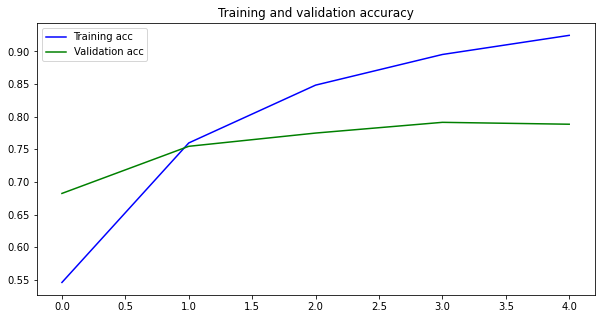

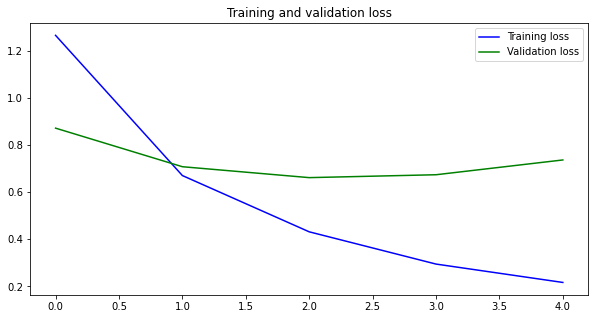

In [320]:
plot_history(history)

# Step 3

Now we unfreeze all layers of the base model and again reduce a learning rate

In [321]:
base_model_02.trainable = True
LR=0.00001
model_02.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(learning_rate=LR), metrics=["accuracy"])
history = model_02.fit(
                    train_generator,
                    steps_per_epoch = train_generator.samples//train_generator.batch_size,
                    validation_data = val_generator, 
                    validation_steps = val_generator.samples//val_generator.batch_size,
                    epochs = 5,
                    callbacks=callbacks_list
                    )

Epoch 1/5
389/389 [==============================] - ETA: 0s - loss: 0.4090 - accuracy: 0.8645 
Epoch 00001: saving model to best_model.hdf5
389/389 [==============================] - 8041s 21s/step - loss: 0.4090 - accuracy: 0.8645 - val_loss: 0.7563 - val_accuracy: 0.7635
Epoch 2/5
389/389 [==============================] - ETA: 0s - loss: 0.2619 - accuracy: 0.9090 
Epoch 00002: saving model to best_model.hdf5
389/389 [==============================] - 7865s 20s/step - loss: 0.2619 - accuracy: 0.9090 - val_loss: 0.7074 - val_accuracy: 0.7787
Epoch 3/5
389/389 [==============================] - ETA: 0s - loss: 0.2110 - accuracy: 0.9270 
Epoch 00003: saving model to best_model.hdf5
389/389 [==============================] - 7820s 20s/step - loss: 0.2110 - accuracy: 0.9270 - val_loss: 0.6718 - val_accuracy: 0.7893
Epoch 4/5
389/389 [==============================] - ETA: 0s - loss: 0.1763 - accuracy: 0.9414 
Epoch 00004: saving model to best_model.hdf5
389/389 [=========================

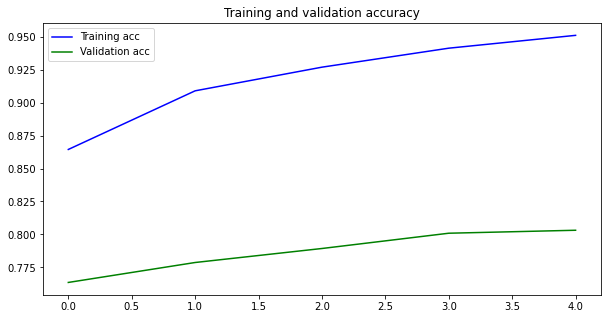

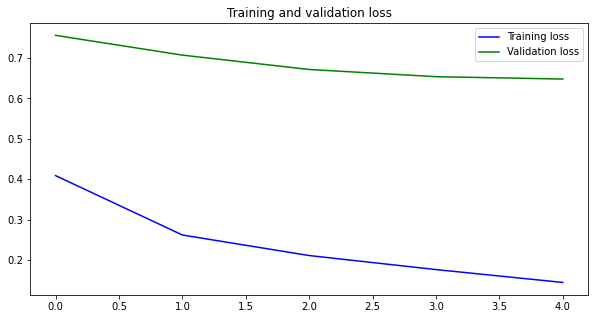

In [322]:
plot_history(history)

In [339]:
#model_02.save('./sf-dl-car-classification_project_7/model_last.hdf5')

In [341]:
model_02.load_weights('best_model.hdf5') 

In [337]:
model_02.evaluate(val_generator, verbose=1)

98/98 [==============================] - 390s 4s/step - loss: 0.6476 - accuracy: 0.8032


[0.647635281085968, 0.8031521439552307]

Let's make predictions and submit them

In [333]:
predictions_02 = model_02.predict(sub_generator) 
predictions_02

array([[2.4379631e-07, 4.0500137e-08, 2.0701453e-04, ..., 1.4335909e-02,
        1.2505980e-06, 9.8544204e-01],
       [6.2365417e-04, 9.2619151e-01, 2.0147342e-04, ..., 2.4329220e-05,
        5.0876837e-02, 1.8137026e-06],
       [1.2333807e-02, 4.6371704e-05, 1.0284344e-01, ..., 4.2152582e-03,
        2.0925938e-03, 1.3644387e-01],
       ...,
       [1.5018838e-05, 9.9723792e-01, 4.9209076e-10, ..., 4.2502389e-08,
        2.7425324e-03, 1.1266121e-07],
       [7.7051629e-07, 3.5383882e-09, 8.2980273e-07, ..., 3.4676227e-06,
        3.4617347e-08, 5.4341926e-06],
       [5.5968868e-11, 6.2083992e-12, 1.1800762e-08, ..., 1.6302068e-06,
        1.6153420e-10, 7.6886972e-06]], dtype=float32)

In [324]:
predictions_02.shape

(6675, 10)

In [334]:
predictions_02_ = np.argmax(predictions_02, axis=-1)
predictions_02_

array([9, 1, 3, ..., 1, 3, 4], dtype=int64)

In [338]:
submission_02 = pd.DataFrame({
    'Id': sub_generator.filenames,
    'Category': predictions_02_
}, columns=['Id', 'Category'])
submission_02.to_csv('submission_02.csv', index=False)

With the help of fine tuning technique, we managed to improve the accuracy